## Objective:
Create relationship between the junctions that are created from the segment dataset in `segment-to-junction-AND-seg_to_seg.ipynb` file and water bodies. 

In [21]:
import geopandas as gpd
import pandas as pd
import fiona
# from ipyfilechooser import FileChooser
from geopandas import GeoSeries

import itertools
from operator import itemgetter

import numpy as np

from scipy.spatial import cKDTree

from shapely.geometry import Polygon, MultiPolygon, shape, Point, LineString
from pyproj import Proj


In [23]:
# create geo point from the csv file

pt_df = pd.read_csv('junctions.csv')
pt_df.columns = ['geometry', 'junction_id']
pt_df.geometry = pt_df.geometry.str.replace('\'','')
pt_df.geometry = pt_df.geometry.str.replace('(','')
pt_df.geometry = pt_df.geometry.str.replace(')','')
def st_to_tuple(x):
    lon, lat = x.split(',')
    return (float(lon), float(lat))
pt_df.geometry = pt_df.geometry.apply(st_to_tuple)
pt_df['lon'] = pt_df.geometry.apply(lambda x:x[0])
pt_df['lat'] = pt_df.geometry.apply(lambda x:x[1])
pt_df.to_csv("y_junstions.csv")

In [24]:
pt_df.head()

,geometry,junction_id,lon,lat
0,"(-57.2097977, 49.464558)",02YL000-0,-57.209798,49.464558
1,"(-57.5601001, 49.5342086)",02YL000-1,-57.560100,49.534209
2,"(-57.6564862, 48.9742214)",02YL000-2,-57.656486,48.974221
3,"(-57.6569614, 49.6810435)",02YL000-3,-57.656961,49.681044
4,"(-57.5447526, 49.5151011)",02YL000-4,-57.544753,49.515101


In [25]:
# create points
pt_df = gpd.GeoDataFrame(
    pt_df, geometry=gpd.points_from_xy(pt_df.lon, pt_df.lat), crs="EPSG:4326")# crs of waterbodies is 4326

<AxesSubplot:>

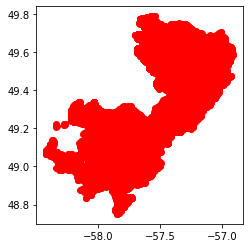

In [26]:
pt_df.plot(color='red')

In [27]:
wb_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HD_WATERBODY_2.shp')

In [28]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,LAKEID_2,RIVID_1,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09..."
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73..."
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53..."
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54..."
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21..."


## Creating water body ID
Similar to segments, as the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [29]:
wb_df['row_index'] = wb_df.index
wb_df['row_index'] = wb_df['row_index'].astype('str')
wb_df['waterbody_id'] = wb_df['DATASETNAM'] + "-" + wb_df.row_index

In [30]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry,row_index,waterbody_id
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09...",0,02YL000-0
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73...",1,02YL000-1
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53...",2,02YL000-2
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54...",3,02YL000-3
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21...",4,02YL000-4


In [31]:

def ckdnearesl_poly(gdfA, gdfB, gdfB_cols, utm_zone = 21):
    """ A is point and B is Polygon """
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.exterior]

    B = np.array(B)
    A = np.array(A)

    Ashape = A.shape
    
    pp = Proj(proj='utm',zone=utm_zone ,ellps='WGS84', preserve_units=False)

    A = np.array(pp(A[:,0].reshape(-1,1), A[:,1].reshape(-1,1))).transpose().reshape((-1,2))

    A = A.reshape(Ashape)


    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    Bshape = B.shape
    B = np.array(pp(B[:,0].reshape(-1,1), B[:,1].reshape(-1,1))).transpose().reshape(Bshape)


    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)

    idx = itemgetter(*idx)(B_ix) 


    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist-meters')], axis=1)
    return gdf


<AxesSubplot:>

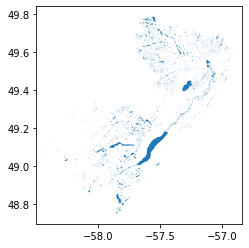

In [32]:
# water body data from open canada needs to be 2d

def ddd_to_dd_poly(g):
    return Polygon([xy[0:2] for xy in list(g.exterior.coords)]) 

wb_df['geometry'] = wb_df.geometry.apply(lambda x: ddd_to_dd_poly(x))
wb_df.plot() 


In [33]:
# columns to keep from waterbody dataframe:
wb_cols = ['waterbody_id'] 
UTM_ZONE = 21
pt_wb_nearept_df = ckdnearesl_poly(pt_df, wb_df, wb_cols,utm_zone=UTM_ZONE)

<ipython-input-31-94e7e63047a9>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array(B)


In [34]:
pt_wb_nearept_df.sort_values('dist-meters')

,geometry,junction_id,lon,lat,waterbody_id,dist-meters
0,POINT (-57.20980 49.46456),02YL000-0,-57.209798,49.464558,02YL000-2144,0.000000
16773,POINT (-57.54068 49.67410),02YL000-16773,-57.540682,49.674099,02YL000-3487,0.000000
16771,POINT (-58.06921 49.16790),02YL000-16771,-58.069205,49.167901,02YL000-6056,0.000000
16770,POINT (-57.82267 49.02510),02YL000-16770,-57.822671,49.025101,02YL000-3145,0.000000
16768,POINT (-57.79923 49.01633),02YL000-16768,-57.799228,49.016331,02YL000-5610,0.000000
...,...,...,...,...,...,...
27680,POINT (-58.13696 49.13335),02YL000-27680,-58.136963,49.133347,02YL000-2354,3746.442424
2390,POINT (-58.33138 49.21317),02YL000-2390,-58.331384,49.213174,02YL000-5250,4219.796704
26557,POINT (-58.33577 49.20765),02YL000-26557,-58.335771,49.207647,02YL000-5250,4635.233037
26841,POINT (-58.33732 49.22060),02YL000-26841,-58.337322,49.220597,02YL000-5250,4646.522489


<AxesSubplot:>

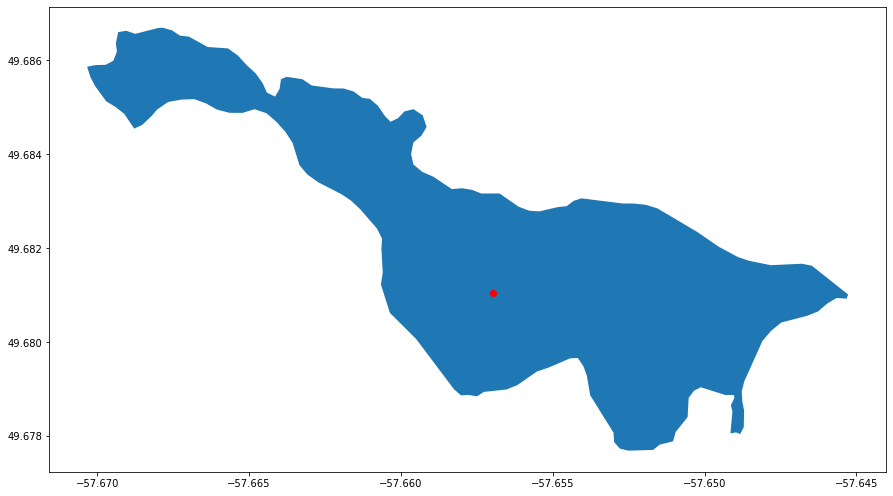

In [18]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
wb_df[wb_df['waterbody_id'] == '02YL000-7672'].plot(ax=ax)
pt_df[pt_df['junction_id'] == '02YL000-3'].plot(color='red', ax= ax)

## Save:
- CSV for database import

In [52]:
pt_wb_nearept_df.to_csv('junction-to-waterbodies.csv', index=False)

In [42]:
pt_wb_nearept_df.drop(['dist-meters'], axis=1).to_csv('y_junction-to-waterbodies.csv', index=False)